<a href="https://colab.research.google.com/github/francesco-cubito97/DLAI_project_3D_NCA/blob/main/Final_DLAI_project_Growing3D_NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and Applied AI project
## *Growing 3D Neural Cellar Automaton*


In [ ]:
# Clone the github repo on content folder
# of google colab machine
!git clone https://github.com/francesco-cubito97/DLAI_project_3D_NCA

# Create the model checkpoints folder
# in a more stable memory, like google drive
from google.colab import drive
drive.mount("/content/gdrive")

Cloning into 'DLAI_project_3D_NCA'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 119 (delta 15), reused 0 (delta 0), pack-reused 93
Receiving objects: 100% (119/119), 10.70 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Mounted at /content/gdrive


In [ ]:
MAIN_FOLDER = "/content/gdrive/MyDrive/DLAI_project_3D_NCA"
OBJECTS_FOLDER = "/content/DLAI_project_3D_NCA/Objects"
BINVOX_PATH = "/content/DLAI_project_3D_NCA"
# Here will save the checkpoints
CHECKPOINTS_FOLDER = MAIN_FOLDER + "/Checkpoints"

# Here I will save gifs
GIFS_FOLDER = MAIN_FOLDER + "/Gifs"

# Here I will save losses to generate plots
LOG_FOLDER = MAIN_FOLDER + "/Logs"

# Here there are some pretrained models
PRETRAINED_FOLDER = "/content/DLAI_project_3D_NCA/Pretrained_models"

import sys
sys.path.append(MAIN_FOLDER)
sys.path.append(BINVOX_PATH)

In [ ]:
# Create all folder and clear all old contents if exist
!mkdir -p $MAIN_FOLDER && rm -f $MAIN_FOLDER/*
!mkdir -p $CHECKPOINTS_FOLDER && rm -f $CHECKPOINTS_FOLDER/*
!mkdir -p $GIFS_FOLDER && rm -f $GIFS_FOLDER/*
!mkdir -p $LOG_FOLDER && rm -f $LOG_FOLDER/*

rm: cannot remove '/content/gdrive/MyDrive/DLAI_project_3D_NCA/Checkpoints': Is a directory
rm: cannot remove '/content/gdrive/MyDrive/DLAI_project_3D_NCA/Gifs': Is a directory
rm: cannot remove '/content/gdrive/MyDrive/DLAI_project_3D_NCA/Logs': Is a directory


In [ ]:
# Import all needed components
import numpy as np
import pandas as pd
from IPython.display import Image
import imageio
import os
from typing import Optional, Callable, Dict, Union

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# Visualization libraries
from torchsummary import summary
import binvox_rw #Taken from https://github.com/dimatura/binvox-rw-py
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
%matplotlib inline
sns.set()
# Reproducibility stuff
import random
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)

# This can be set also to False with performance improvement
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False

In [ ]:
# Global variables
BINVOX_PATHS = {
    "cow": "/cow_minecraft_14x8x16.binvox",
    "fox": "/fox_minecraft_7x10x16.binvox",
    "wolf": "/wolf_minecraft_16x5x9.binvox",
}
for p in BINVOX_PATHS:
    BINVOX_PATHS[p] = OBJECTS_FOLDER + BINVOX_PATHS[p]
    print(f"Element: {p}, path:{BINVOX_PATHS[p]}")

# Some useful color
COLORS = {
    "cow": to_rgb("#f2cB68"),
    "fox": to_rgb("#df5d5d"),
    "wolf": to_rgb("#42b0c1")
}

# Training variables
N_CHANNELS = 32
DIM = 16
PADDING = 4
TOT_ITERATIONS = 16000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE}')

Element: cow, path:/content/DLAI_project_3D_NCA/Objects/cow_minecraft_14x8x16.binvox
Element: fox, path:/content/DLAI_project_3D_NCA/Objects/fox_minecraft_7x10x16.binvox
Element: wolf, path:/content/DLAI_project_3D_NCA/Objects/wolf_minecraft_16x5x9.binvox
Using device: cuda:0


In [ ]:
def loadBinvox(path):
    '''
    Load binvox model and convert it into numpy array
    for simplicity
        
        Params
        ------
        - path: path of the model

        Returns
        -------
        - voxels numpy array
    '''
    with open(path, 'rb') as f:
        voxels = binvox_rw.read_as_3d_array(f)
    
    return np.array(voxels.data, dtype=bool)

def plotVoxels(voxels, title : str="Voxels models", figsize : tuple=(10, 10), c=None) -> None:
    '''
    Plot voxels starting from numpy array
        
        Params
        ------
        - voxels: numpy array of boolean voxels
        - figsize: dimension in inches of image
        - c: color to use in rgba. Can be a single float, a list of 3/4 float in [0, 1] or [0, 255] range or a 4D array of RGB/RGBA colors, one for each voxel
        
        Returns
        -------
        - `None`
    '''
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(projection="3d")

    if c is not None: colors = c # Set to middle gray
    else: colors = [0.5, 0.5, 0.5]
    
    ax.voxels(voxels, facecolor=colors, edgecolor=[1.0, 1.0, 1.0])
    
    # Change point of view of camera
    #ax.set_title(f"View {abs(i*(360//tot))} degree")
    #ax.view_init(0, i*(360//tot))

    fig.suptitle(title, fontsize=figsize[0]*4)
    plt.show()

def createBox(obj):
    '''
    Calculate the box around a 3d object
        
        Params
        ------
        - obj: space in which lies the 3d object

        Returns
        -------
        - 3d box object
    '''
    # Get coordinates of the object
    coord = (obj > 0).nonzero()

    # Calculate where each dimension starts and ends
    # for the object
    start_x = torch.min(coord[:, 0]) 
    size_x = torch.max(coord[:, 0]) - start_x + 1
    
    start_y = torch.min(coord[:, 1])
    size_y = torch.max(coord[:, 1]) - start_y + 1
    
    start_z = torch.min(coord[:, 2])
    size_z = torch.max(coord[:, 2]) - start_z + 1
    

    # Create the parallelepiped with the defined dimensions
    x = slice(start_x, start_x + size_x)
    y = slice(start_y, start_y + size_y)
    z = slice(start_z, start_z + size_z)

    parallelepiped = torch.zeros_like(obj)
    parallelepiped[x, y, z] = 1.0

    return parallelepiped.clone().detach()

def centerObj(obj):
    '''
    Centralize a 3d object in the space in which it lies
        
        Params
        ------
        - obj: the object that should be centralized

        Returns
        -------
        - The centered object
    '''
    # Get center of the space
    center_s = torch.tensor([obj.shape[0]//2, obj.shape[1]//2, obj.shape[2]//2])

    ## To center the object we need to count how many
    ## vertices of distance there are between the
    ## center position and the center of the parallelepiped

    # Get the box around the object
    p = createBox(obj)
    
    # Get the parallelepiped coordinates
    coord = (p > 0).nonzero()
    
    # Sum all voxels coordinates and average to get centroid
    sum = coord.sum(dim=0)
    centroid = torch.div(sum, coord.shape[0], rounding_mode="floor")

    # Get the shift value in voxels between the two centers
    shift = tuple(center_s - centroid)


    # Move the object to the center of the space
    # based on the box center calculated
    obj = torch.roll(obj, shift, (0, 1, 2))

    # Get the parallelepiped coordinates
    coord = (obj > 0).nonzero()
    
    # Average to get centroid
    sum = coord.sum(dim=0)
    centroid = torch.div(sum, coord.shape[0], rounding_mode="floor")

    return obj

# One temptative to speed up the training
def erosion3D(obj):
    '''
    Morphological 3d erosion of object
        
        Params
        ------
        - obj: the object that should be eroded

        Returns
        -------
        - Eroded object
    '''
    # Create a copy of the object 
    o = obj.clone().detach()
    # Create the 3D average pool operation
    avgP1 = nn.AvgPool3d((1, 1, 3), stride=(1, 1, 1))
    avgP2 = nn.AvgPool3d((1, 3, 1), stride=(1, 1, 1))
    avgP3 = nn.AvgPool3d((3, 1, 1), stride=(1, 1, 1))
    # Return the mask of elements
    mask1 = F.pad(avgP1(o) < 1.0, [1, 1, 0, 0, 0, 0])
    mask2 = F.pad(avgP2(o) < 1.0, [0, 0, 1, 1, 0, 0])
    mask3 = F.pad(avgP3(o) < 1.0, [0, 0, 0, 0, 1, 1])
    
    print(mask1.shape, mask2.shape, mask3.shape)

    # Invert the mask
    mask = ~(mask1 & mask2 & mask3)
    
    # Multiply the mask to the original
    # object to erode it
    return o * mask.float()

In [ ]:
# Loading all binvox models and visualizing them
target_objects = {
    "cow": None,
    "fox": None,
    "wolf": None
}

o = "cow"
vx = loadBinvox(BINVOX_PATHS[o])
# Rotate to adjust
target_objects[o] = torch.tensor(np.rot90(vx, k=1, axes=(2, 1)).copy())
target_objects[o] = F.pad(target_objects[o], [PADDING, PADDING, PADDING, PADDING, PADDING, PADDING])
target_objects[o] = centerObj(target_objects[o]).float()

o = "fox"
vx = loadBinvox(BINVOX_PATHS[o])
target_objects[o] = torch.tensor(np.rot90(vx, k=1, axes=(0, 1)).copy())
target_objects[o] = F.pad(target_objects[o], [PADDING, PADDING, PADDING, PADDING, PADDING, PADDING])
target_objects[o] = centerObj(target_objects[o]).float()

o = "wolf"
vx = loadBinvox(BINVOX_PATHS[o])
target_objects[o] = torch.tensor(np.rot90(np.rot90(vx, k=2, axes=(0, 1)), k=1, axes=(1, 2)).copy())
target_objects[o] = F.pad(target_objects[o], [PADDING, PADDING, PADDING, PADDING, PADDING, PADDING])
target_objects[o] = centerObj(target_objects[o]).float()


for key in target_objects:
    print(target_objects[key].shape)


torch.Size([24, 24, 24])
torch.Size([24, 24, 24])
torch.Size([24, 24, 24])


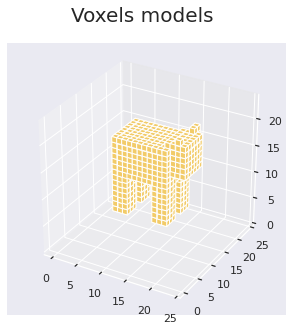

Object shape torch.Size([24, 24, 24])


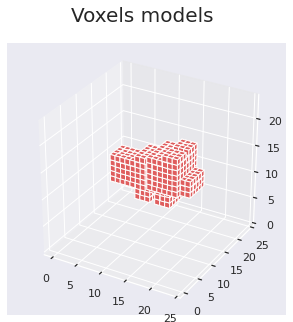

Object shape torch.Size([24, 24, 24])


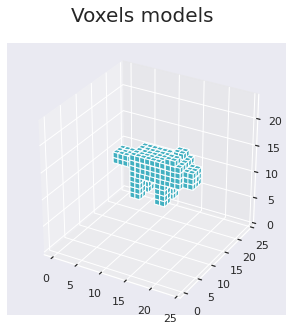

Object shape torch.Size([24, 24, 24])


In [ ]:
# Visualize the result
for key in target_objects:
    plotVoxels(target_objects[key].numpy(), figsize=(5, 5), c=COLORS[key])
    print("Object shape", target_objects[key].shape)

## Project details
Now the steps are consequential. We should obtain a neural network able to output at each time step a new configuration of the final object in 3D voxels, each one with a certain probability of existence that is dependent, like in the original paper, on a value that we will call $\alpha$, that will represent the live itself.
In our case:
\begin{align}
       0 \le \alpha \le 1
\end{align}
and  will have the folling meaning:
- $0\le \alpha < 0.1$: dead cell
- $0.1\le \alpha < 0.5$: growing cell 
- $0.5\le \alpha \le1$: mature cell

The network will be composed of an initial layer that will make a 3D convolutional operation with *Sobel Filter* (taken from [here](https://https://stackoverflow.com/questions/7330746/implement-3d-sobel-operator)):
><img src="https://i.stack.imgur.com/73lM4.png" alt="sobel_x" width="300"/>
><img src="https://i.stack.imgur.com/gtW6o.png" alt="sobel_y" width="300"/>
><img src="https://i.stack.imgur.com/11ekC.png" alt="sobel_z" width="300"/>

The central cell will be passed directly, without any filter (identity filter).


In [ ]:
#@title Sobel filters and identity filter
# 3D Sobel filters to make a comparison with the one
# found during training
SF_X = torch.tensor([
                        [[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]],
                        [[-2, 0, 2],
                         [-4, 0, 4],
                         [-2, 0, 2]],
                        [[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]],
                         ]).float()
# Normalize the values for the application of the convolutions 
# with the (filter.x * filter.y * filter.z) neighbors
neighbors = SF_X.shape[0] * SF_X.shape[1] * SF_X.shape[2] - 1

SF_X = SF_X/neighbors
SF_Y = torch.einsum("xyz -> xzy", SF_X)
SF_Z = torch.einsum("xyz -> zyx", SF_X)

print(SF_X , "\n")
print(SF_Y , "\n")
print(SF_Z , "\n")

# Identity filter
IDF = torch.tensor([0, 1, 0]).float()
IDF = torch.einsum("a, b, c -> abc", IDF, IDF, IDF)
print(IDF)

tensor([[[-0.0385,  0.0000,  0.0385],
         [-0.0769,  0.0000,  0.0769],
         [-0.0385,  0.0000,  0.0385]],

        [[-0.0769,  0.0000,  0.0769],
         [-0.1538,  0.0000,  0.1538],
         [-0.0769,  0.0000,  0.0769]],

        [[-0.0385,  0.0000,  0.0385],
         [-0.0769,  0.0000,  0.0769],
         [-0.0385,  0.0000,  0.0385]]]) 

tensor([[[-0.0385, -0.0769, -0.0385],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0385,  0.0769,  0.0385]],

        [[-0.0769, -0.1538, -0.0769],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0769,  0.1538,  0.0769]],

        [[-0.0385, -0.0769, -0.0385],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0385,  0.0769,  0.0385]]]) 

tensor([[[-0.0385, -0.0769, -0.0385],
         [-0.0769, -0.1538, -0.0769],
         [-0.0385, -0.0769, -0.0385]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0385,  0.0769,  0.0385],
         [ 0.0769,  0.1538,  0

torch.Size([32])


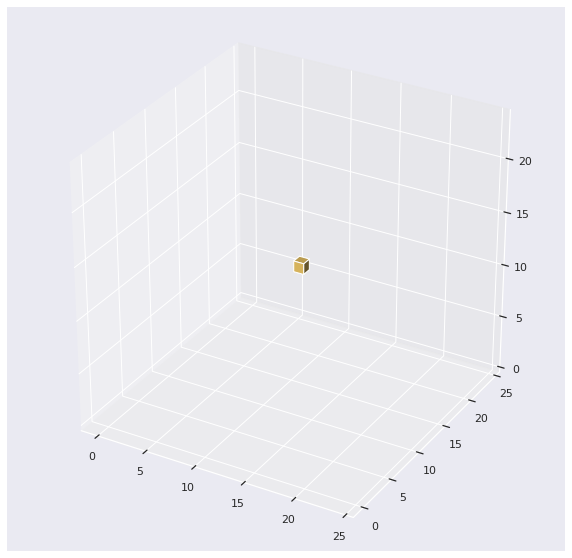

In [ ]:
def randVoxel(obj):
    '''
    Select randomly a voxel in a 3d object
        
        Params
        ------
        - obj: the object in which pick the random voxel

        Returns
        -------
        - `None`
    '''
    # Get the list of possible coordinates where to pick the random value
    coord = (obj > 0.0).nonzero()

    # Pick the seed between coordinates
    n = torch.randint(coord.shape[0], []).item()
    
    return tuple(coord[n])

def initCA(dim, channels, obj, random_seed=False):
    '''
    Initialize virtual 3D cells lattice
        
        Params
        ------
        - dim: dimension of the 3d space
        - channels: channels of the 3d space
        - obj: the object from which pick the seed voxel
        - random_seed: use a random cell in the object

        Returns
        -------
        - Tensor of cells with seed
    '''
    # Create the lattice of dim x dim x dim dimension
    cells = torch.zeros((channels, dim, dim, dim), dtype=torch.float32)
    
    # Get the random voxel
    if random_seed:   
        vx = randVoxel(obj)
 
        x, y, z = vx[0], vx[1], vx[2]
        # The seed cell will have all features values equal to one
        cells[:, x, y, z] = 1.0

    # Return only the central seed
    else:
        cells[:, dim//2, dim//2, dim//2] = 1.0
    
    return cells

# Cells space
dim = DIM+2*PADDING
cells = initCA(dim, N_CHANNELS, target_objects["cow"])
cellsN = torch.einsum("cdhw -> dhwc", cells)

# Extract the alpha channel
alpha = cells[:1, ...].clone().detach()
alphaN = torch.einsum("cdhw -> dhwc", alpha)

# Set RGBA colors of cells. Died cells wiil have alpha = 0.0
colorsN = torch.zeros((dim, dim, dim, 4))
colorsN[..., :3] = torch.tensor(COLORS["cow"]) # To have a gray color
colorsN[..., 3:] = alphaN
print(cells[cells > 0].shape)

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(cellsN[..., 0].numpy(), facecolors=colorsN, edgecolor="white")
plt.show()

In [ ]:
# Utils
def countParameters(model: torch.nn.Module) -> int:
    """ 
    Counts the number of trainable parameters of a module
        
        Params
        ------
        - model: model that contains the parameters to count
    
        Returns
        -------
        - the number of parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def getLivingMask(x):
    """
    Create a mask of alive cells seeing at alpha channel
        
        Params
        ------
        - x: input 3d object

        Returns
        -------
        - boolean mask of living cells
    """
    # The alpha values are in the first channel
    alpha = x[:, :1, :, :, :].clone()
    # Return a boolean mask that is true in 3x3x3 neighbors
    # maximum with an alpha value higher than 0.1, so if the maximum neighbor
    # cell is mature
    return F.max_pool3d(alpha, kernel_size=3, stride=1, padding=1) > 0.1

def normWeights(weight):
    '''
    Normalize weights to avoid exploding gradients problem
        
        Params
        ------
        - weight: weights data to be normalized
        
        Returns
        -------
        - normalized weights
    '''
    w = weight.view(1, -1).clone().detach()
    with torch.no_grad():
        # Inplace division
        w.div_(torch.norm(w, dim=1, keepdim=True))
    
    return w.view(weight.shape)

def weightsInit(smodel, slow_train=False):
    '''
    Initialize weights 3D convolutional layers in sequential component
        
        Params
        ------
        - smodel: sequential model
        - slow_train: init the last layer with zeros to slow the convergency

        Returns
        -------
        - `None`
    '''
    for idx, layer in enumerate(smodel):
        if isinstance(layer, nn.Conv3d) and idx != 4:
            print(f"Layer {layer} initialized with He initialization")
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        elif idx == 4:
            # Initialize the last 1x1x1 convolutional layer with zeros
            # otherwise the network will not learn to construct step-by-step
            # like a Cellular Automaton does
            print(f"Layer {layer} initialized with zeros")
            nn.init.zeros_(layer.weight)
      
       

In [ ]:
# Create 3D CA module like an RNN
# to use backpropagation through time
class CA3D(nn.Module):
    def __init__(self, input_channels: int, kernel_size: int, output_size: int, depthwise_filter=None, device="cuda") -> None:
        '''
        CA3D Neural Network initialzation
            
            Params
            ------
            - input_channels: number of input channels
            - kernel_size: dimension of filters in depthwise convolutions
            - output_size: number of channels in output
            - depthwise_filter: kernel values of 3x3x3 depthwise filter
            - device: device in which the module is executed 

            Returns
            -------
            - `None`
        '''
        super(CA3D, self).__init__()
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_size = output_size
        self.fire_rate = 0.5
        self.device = device

        # Must be trained end-to-end
        # I would like to obtain the same shape of output that
        # I would obtain using Sobel Filters
        self.identity_kernel = IDF.view(1, 1, self.kernel_size, self.kernel_size, self.kernel_size).repeat(self.input_channels, 1, 1, 1, 1).to(self.device)
        
        # The result from this filter must be concatenated with the result
        # obtained applying the identity filter
        self.depthwise_filter = nn.Conv3d(in_channels=input_channels, out_channels=3*input_channels, 
                                         kernel_size=kernel_size, padding="same",
                                         groups=input_channels, bias=False)
        
        if depthwise_filter is not None:
            # Use an already filled filter
            self.depthwise_filter.weight.data = depthwise_filter
            self.depthwise_filter.requires_grad_(False)
        
        self.dmodel = nn.Sequential(
            # First 3d convolution: 128 -> 192, 1x1 conv
            nn.Conv3d(input_channels*4, input_channels*6, kernel_size=1, bias=False),
            # Activation function
            nn.LeakyReLU(),
            # Second 3d convolution: 192 -> 96, 1x1 conv
            nn.Conv3d(input_channels*6, input_channels*3, kernel_size=1, bias=False),
            # Activation function
            nn.LeakyReLU(),
            # Third 3d convolution: 96 -> 32, 1x1 conv
            nn.Conv3d(input_channels*3, output_size, kernel_size=1, bias=False)
        )

    def neighPerc(self, x):
        '''
        3x3x3 neighbors perception using gradients plus identity value
            
            Params
            ------
            - x: 3d model in input

            Returns
            -------
            - Perception tensor
        '''
        # Apply the Depthwise 3d convolution
        # First apply identity filter depthwise
        id_res = F.conv3d(x, self.identity_kernel, padding="same", groups=self.input_channels)
 
        # Apply the filter trained depthwise  
        filter_res = self.depthwise_filter(x)

        # Concatenate the two results
        perception = torch.concat([id_res, filter_res], 1)
        
        return perception

    def forward(self, x, fire_rate=None, perception_result=False, bef_alive=False):
        '''
        Forward-pass through the network to create computational graph
            
            Params
            ------
            - x: Input 3d object
            - fire_rate: updatable cells minumum value

            Returns
            -------
            - Output 3d object
        '''
        pre_life_mask = getLivingMask(x)
        
        # Depthwise convolutions over 3x3x3 neighborhood
        perception = self.neighPerc(x)
        
        # Perception of neighbors gradients values
        neigh_grad = self.dmodel(perception)

        if fire_rate is None:
            fire_rate = self.fire_rate
        # Stochastic update of the alpha channel
        # Get a boolean mask to update only cells 
        # with a value smaller than or equal to fire_rate
        update_mask = torch.rand(x[:, :1, ...].shape, device=self.device) <= fire_rate
        
        # Control the update only of the alpha channel
        x = x + (neigh_grad * update_mask.float())

        post_life_mask = getLivingMask(x)
        # Alive mask, maintain alive only the
        # cells alive before and after computations
        life_mask = pre_life_mask & post_life_mask
        out = x * life_mask.float()

         # Visulize the perception
        if perception_result and bef_alive:
            return perception, x, out

        return out 

In [ ]:
#@title Choose the model to train
model_type = "Trainable perception filter" #@param ["Trainable perception filter", "Fixed perception filter"]
# Model with trainable initial filter
# Instantiate the model
if model_type == "Trainable perception filter":
    mod = "tpf"
    ca3d = CA3D(input_channels=N_CHANNELS, kernel_size=3, output_size=N_CHANNELS, device=DEVICE)
else:
    # Compose sobel filters
    mod = "fpf"
    l = []
    for f in [SF_X, SF_Y, SF_Z]:
        l.append(f.view(1, 1, 3, 3, 3).repeat(N_CHANNELS, 1, 1, 1, 1))
    sobel_filter = torch.concat(l, 0)

    ca3d = CA3D(input_channels=N_CHANNELS, kernel_size=3, output_size=N_CHANNELS, depthwise_filter=sobel_filter, device=DEVICE)

# Initialize last three layers of model
weightsInit(ca3d.dmodel)

ca3d = ca3d.to(DEVICE)

# Visualize layers and output dimensions
print(ca3d)
print(f"Number of parameters: {countParameters(ca3d)}")
print("\n\n")
summary(ca3d, cells.shape, batch_size=1)

Layer Conv3d(128, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False) initialized with He initialization
Layer Conv3d(192, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False) initialized with He initialization
Layer Conv3d(96, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False) initialized with zeros
CA3D(
  (depthwise_filter): Conv3d(32, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, groups=32, bias=False)
  (dmodel): Sequential(
    (0): Conv3d(128, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv3d(192, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv3d(96, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
)
Number of parameters: 48672



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [1, 96, 24, 24, 24]          

## **Training phase**

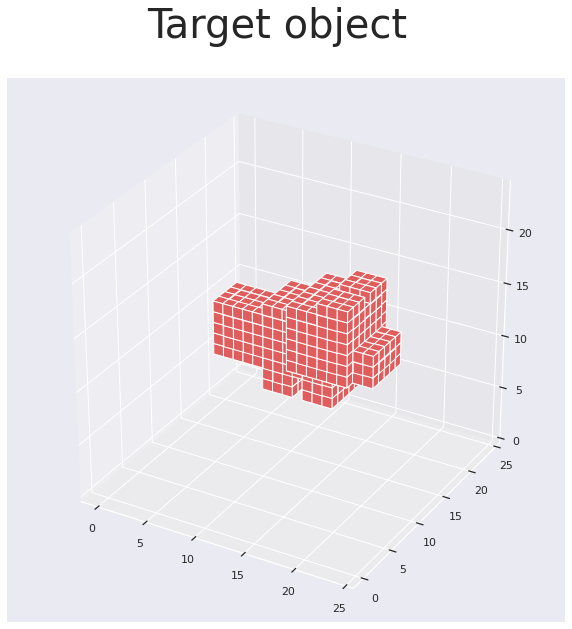

Target object shape: torch.Size([1, 1, 24, 24, 24]), dtype: torch.float32


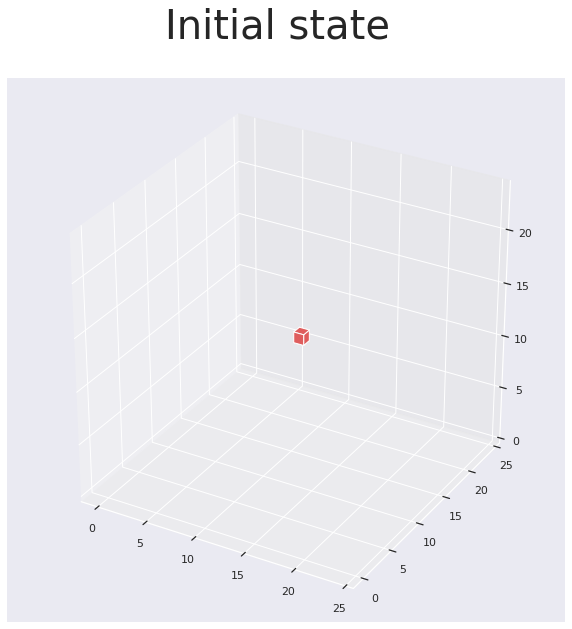

Seed shape: torch.Size([1, 32, 24, 24, 24]), dtype: torch.float32
Initial loss value: 0.04116030037403107


In [ ]:
#@title Choose the target
obj = "fox" #@param ["cow", "fox", "wolf"]
target = target_objects[obj][None, None, :, :, :].clone().detach()

plotVoxels(target[0, 0].numpy(), title="Target object", c=COLORS[obj])
print(f"Target object shape: {target.shape}, dtype: {target.dtype}")

# Initialize the cells
seed = initCA(target.shape[2], N_CHANNELS, target[0, 0])[None, ...]
plotVoxels(seed[0, 0].numpy(), title="Initial state", c=COLORS[obj])
print(f"Seed shape: {seed.shape}, dtype: {seed.dtype}")

# Loss criterion
lossFunc = nn.L1Loss()
def error(x, target):
    return lossFunc(torch.clamp(x[:, 0], min=0.0, max=1.0), target[:, 0])

print(f"Initial loss value: {error(seed, target)}")

# Optimizer with L2-regularization and momentum
lr = 5e-3 if mod == "fpf" else 3e-3
wd = 1e-5
m = 0.8
opt = optim.SGD(ca3d.parameters(), lr=lr, weight_decay=wd)


In [ ]:
def loadCheckpoint(path, model, opt):
    '''
    Load a model checkpoint specifing the path
        
        Params
        ------
        - path: path of the model checkpoint
        - model: reference to the model
        - opt: reference to the optimazer

        Returns
        -------
        - epoch and loss of the model checkpoint
    '''
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return checkpoint['n_iter'], checkpoint['loss']
    

def saveCheckpoint(path, model_sd, opt_sd, n_iter, loss):
    '''
    Save a model checkpoint into a specified path location
        
        Params
        ------
        - path: path in which save the modelcheckpoint
        - model_sd: model state dictionary
        - opt_sd: optimizer state dictionary
        - n_iter: last number iteration of the model
        - loss: loss at last iteration

        Returns
        -------
        - `None`
    '''
    torch.save({
        'n_iter': n_iter,
        'model_state_dict': model_sd,
        'optimizer_state_dict': opt_sd,
        'loss': loss
    }, path)

In [ ]:
def trainStep(x, target, model: torch.nn.Module, opt: torch.optim.Optimizer,  device: str = "cuda"):
    '''
    Training iteration of the model
        
        Params
        ------
        - x: Input 3d object
        - target: Target 3d object
        - model: model to train
        - opt: optimizer
        - device: type of device in which make calculous

        Returns
        -------
        - Model output and loss reached
    '''
    model.train()
    
    # Send to device
    x, target = x.to(device), target.to(device)
    # Try with a random number of iterations
    n_iter = torch.randint(85, 100, []).item()

    # Create a local variable
    _x = x.clone().detach()
    _x.requires_grad_(True)
    
    for i in range(n_iter):
        # Iterate the model without backpropagate
        # to use always the same set of learned rules
        # (otherwise calling backpropagation the rules changes)
        _x = model(_x)

        # Truncated Backpropagation through time
        # Every 5 iterations backpropagate
        '''
        if (i+1)%5 == 0:
            opt.zero_grad()
            loss = error(_x, target)
            
            #if(i+1)%50: print(f"Internal loss: {loss}")
            #wandb.log({"Internal_loss": loss})
            
            loss.backward()
            # Avoid exploding gradient
            #nn.utils.clip_grad_norm_(model.parameters(), .7)

            opt.step()

            _x = _x.clone().detach()
            _x.requires_grad_(True)
            #print("Done!")'''
  
    # Each #iter steps   
    # Calculate the loss and backpropagate through time
    opt.zero_grad()
    loss = error(_x, target)
    
    loss.backward()
    # Avoid exploding gradient
    #nn.utils.clip_grad_norm_(model.parameters(), .7)
    opt.step()

    return _x.clone().detach(), loss.clone().detach()

In [ ]:
# Training iterations 
x = seed.clone().detach()
x.requires_grad_(True)

losses = []

checks = [1000, 1500, 2000, 3000, 4000, 6000, 8000, 12000, 16000]
i = 0

for n_iter in range(1, TOT_ITERATIONS+1):   
    # Start each new iteration with single cell
    out, loss = trainStep(x, target, model=ca3d, opt=opt, device=DEVICE)

    # Print the reached loss
    print(f"At iteration: {n_iter: 4d} Reached loss: {loss}\n")
    
    losses.append(loss.item())

    # Early stopping
    if(loss.item() <= 0.001):
        print("Reached early stopping point!")
        saveCheckpoint(f"{CHECKPOINTS_FOLDER}/checkpoint_{mod}_{n_iter}_{obj}.pth", ca3d.state_dict(), opt.state_dict(), n_iter, loss)

        # Save loss and empty list
        torch.save(torch.tensor(losses), f"{LOG_FOLDER}/losses_{mod}_{n_iter}_{obj}.pt")
        break

    # Save checkpoint
    if n_iter%checks[i] == 0:
        i += 1
        saveCheckpoint(f"{CHECKPOINTS_FOLDER}/checkpoint_{mod}_{n_iter}_{obj}.pth", ca3d.state_dict(), opt.state_dict(), n_iter, loss)
        
        # Save loss and empty list
        torch.save(torch.tensor(losses), f"{LOG_FOLDER}/losses_{mod}_{n_iter}_{obj}.pt")
        losses = []

In [ ]:
# Format the path
loss_conc = np.array([])
for c in range(len(checks)):
    path = f"{LOG_FOLDER}/losses_{mod}_{checks[c]}_{obj}.pt"
    inp = torch.load(path).to(DEVICE)
    loss_conc = np.concatenate((loss_conc, inp.cpu().numpy()))

print(loss_conc.shape)
   

In [ ]:
# Plot the result of training
from cycler import cycler
ax = plt.figure(figsize=(10, 8)).subplots()
ax.set_prop_cycle(cycler(color=["tab:blue", "tab:orange"]))
ax.plot(loss_conc, linestyle=(0, (3, 10, 1, 10)), linewidth=1.5)

ax.set_title(f"Losses plot {mod} filter {obj}")

l = f"Fixed {obj}" if mod == "fpf" else f"Trained {obj}"
plt.legend([l], ncol=2, loc='upper left')
plt.savefig(f"{MAIN_FOLDER}/plot_loss_cow.png")

## **Model Evaluation**

In [ ]:
# Load the last network that should be the most robust
if i != 0:
    _iter, _loss = loadCheckpoint(f"{CHECKPOINTS_FOLDER}/checkpoint_{mod}_{checks[i-1]}_{obj}.pth", ca3d, opt)

    print(f"Checkpoint saved at iteration number: {_iter}, Loss: {_loss}")
else:
    print("Error! Execute training section at least 1000 iterations or \nskip this section and use pretrained model")

Checkpoint saved at iteration number: 1000, Loss: 0.04107033088803291


In [ ]:
#@title To use pretrained models
mod = "tpf" #@param ["fpf", "tpf"] 
obj = "fox" #@param ["cow", "fox"]
_iter, _loss = loadCheckpoint(f"{PRETRAINED_FOLDER}/checkpoint_{mod}_{16000}_{obj}.pth", ca3d, opt)

print(f"Checkpoint saved at iteration number: {_iter}, Loss: {_loss}")

Checkpoint saved at iteration number: 16000, Loss: 0.0042030541226267815


In [ ]:
# Visualize the capability to represent the cow
def eval_model(model, saved_out, save_intermediate=False):
    '''
    Evaluate the model
        Params
        ------
        - model: the model to be evaluated
        - saved_out: list of saved output tensors
        - save_intermediate: boolean, if true the function returns perception tensor, updating tensor and final output at 80th time step
        
        Returns
        -------
        - the modified saved_out
    '''
    # Iterate to 100 times to create the object
    for i in range(1, 100):
        
        model.eval()
        
        with torch.no_grad():
            inp = torch.load(saved_out[-1]).to(DEVICE)
            if i == 80 and save_intermediate==True:
                p, b, out_ext = ca3d(inp, perception_result=True, bef_alive=True)
            else: out = ca3d(inp)
            
            filename = f"{i}"
            torch.save(out.cpu().clone().detach(), filename)
            saved_out.append(filename)

            del out
            del inp
        torch.cuda.empty_cache()

    print(f"Number of saved outputs: {len(saved_out)}")
    if save_intermediate:
        return p, b, out_ext
    

In [ ]:
# Visualize the outputs
def visualizeOutputs(saved_out,  dim, iter_gif=100):
    for i in range(len(saved_out)):
        cells = torch.zeros((1, N_CHANNELS, dim, dim, dim)) 
        # A cell will exist only if its values is different from zero
        alpha = torch.load(saved_out[i%iter_gif])[0, :1, ...].cpu()
        
        # Clamp largest/smallest values
        alpha = torch.clamp(alpha, min=0, max=1)
        cells[0, :1, ...] = alpha
        cellsN = cells.numpy()[0, 0, ...]

        # Adapt alpha channel to be visualizable
        alpha = torch.einsum("cdhw -> dhwc", alpha)
        alphaN = alpha.numpy()

        colorsN = np.zeros((dim, dim, dim, 4)) 
        colorsN[..., :3]  = COLORS[obj] # This is to obtain gray in r,g,b
        colorsN[..., 3:4] = alphaN

        # The first channel represent the alpha and will be
        # the unique relevant for us
        ax = plt.figure().add_subplot(projection="3d")
        ax.voxels(cellsN, facecolors=colorsN, edgecolors=colorsN)
        
        # Save the frame
        plt.savefig(saved_out[i%iter_gif] + ".png")
        plt.close()

        # Create a gif with each model saved images
        if (i+1)%iter_gif == 0:
            print(f"Creating the gif for model_n_{i+1}...")
            # Build gif
            with imageio.get_writer(f'{GIFS_FOLDER}/{obj}_model_{mod}_n_{i+1}.gif', mode='I') as writer:
                for k in range(iter_gif):
                    # Extract path and free saved_x
                    path = saved_out[0]
                    del saved_out[0]

                    # Compose the gif
                    try:
                        image = imageio.imread(path + ".png")
                        writer.append_data(image)
                        # Remove useless files from disk
                        os.remove(path)
                        os.remove(path + ".png")
                    except:
                        print(f"Not found file: {path}.png at iteration {i} and gif iteration {k}")
                    
                    
            print(f"Done! Now saved are {len(saved_out)}")

In [ ]:
# Visualize the capability to represent the object
x = seed.clone().detach().to(DEVICE)

# Iterate to 100 times to create the object
torch.save(x.cpu().clone().detach(), "0")
saved_out = []
saved_out.append("0")

eval_model(ca3d, saved_out)

Number of saved outputs: 100


In [ ]:
visualizeOutputs(saved_out, dim=DIM+2*PADDING)

Creating the gif for model_n_100...
Done! Now saved are 0
